In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def safe_convert(col):
    col_cleaned = col.replace(',', '', regex=True)
    return pd.to_numeric(col_cleaned, errors='coerce')

setpt = pd.read_csv('setpoint_publish(in).csv')
setpt = setpt.apply(lambda col: safe_convert(col) if col.name != 'var' else col)
setpt



,var,opt_mean,opt_sig,drift_mean,drift_sig,excursion_mean,excursion_sig
0,x1,22.1,0.295,22.111,0.442,22.115,0.5900
1,x2,44.8,1.045,46.010,1.840,46.547,2.3270
2,x4,0.4,0.023,0.368,0.027,0.304,0.0670
3,x5,150000.0,8000.000,135000.000,9000.000,120000.000,16000.0000
4,x7,1206.0,48.240,1266.300,75.978,1266.300,88.6410
5,x8,87.0,5.220,91.176,6.686,107.880,12.2264
6,x9,454.0,19.673,456.270,22.814,599.280,69.9160
7,x17,5492.0,256.293,5526.050,349.983,5552.410,425.6850
8,x3,NaN,NaN,39.000,2.860,NaN,NaN
9,x6,NaN,NaN,112.000,6.720,NaN,NaN


In [3]:
def generate_normal_data(mean, std_dev, size=5000, seed=None):
    return np.random.normal(loc=mean, scale=std_dev, size=size)

def generate_skewed_normal_data(mean, std_dev, skew, size=5000, seed=None):
    return skewnorm.rvs(skew, loc=mean, scale=std_dev, size=size)

In [4]:
datasets = {}
skew_params = {
    "x4": 200,
    "x5": 200,
    "x8": -100,
    "x9": -200
}

for data_name in ["opt", "drift", "excursion"]:
    rows = []
    for var, mean, sig in zip(setpt['var'], setpt[f'{data_name}_mean'], setpt[f'{data_name}_sig']):
        if data_name == "excursion" and var in skew_params:
            # Generate skewed data for the specified variables (x4, x5, x8, x9)
            skew = skew_params[var]
            rows.append(generate_skewed_normal_data(mean=mean, std_dev=sig, skew=skew, size=5000, seed=42))
        else:
            # Generate normal data for other variables
            rows.append(generate_normal_data(mean=mean, std_dev=sig, size=5000, seed=42))

    # Assign the generated data to the dataset
    datasets[data_name] = pd.DataFrame(np.column_stack(rows), columns=setpt['var'])

In [5]:
opt_data = datasets['opt']
drift_data = datasets['drift']
exc_data = datasets['excursion']

# Outcome 

In [6]:
opt_data['outcome'] = (-( 5 * np.pi * 10**4 * opt_data['x1'] + 770 * (opt_data['x2'] ** 2) +
    58 * opt_data['x5'] * opt_data['x4'] - 890 * opt_data['x17'] + 730.5 * opt_data['x7'] ) / (8 * 10**5) + 7.5)


drift_data['outcome'] = (-( 5 * np.pi * 10**4 * drift_data['x1'] + 770 * (drift_data['x2'] ** 2) +
    58 * drift_data['x5'] * drift_data['x4'] - 890 * drift_data['x17'] + 730.5 * drift_data['x7'] ) / (8 * 10**5) 
    + (39 * drift_data['x5'] * drift_data['x9'] * drift_data['x8']) / (10**11) + 7)

exc_data['outcome'] = (-( 5 * np.pi * 10**4 * exc_data['x1'] + 770 * (exc_data['x2'] ** 2) +
    58 * exc_data['x5'] * exc_data['x4'] - 890 * exc_data['x17'] + 730.5 * exc_data['x7'] ) / (8 * 10**5) 
    + (39 * exc_data['x5'] * exc_data['x9'] * exc_data['x8']) / (10**11) + 7 
    + ((0.8 * exc_data['x4'] * (exc_data['x5'])**2 * exc_data['x17'] ) / (10**13)))


In [7]:
opt_data.head()

var,x1,x2,x4,x5,x7,x8,x9,x17,x3,x6,x10,x11,x12,x13,x14,x15,x16,x18,x19,outcome
0,22.247212,43.929164,0.409396,158821.429981,1262.485607,83.209765,461.819644,5751.004870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.805539
1,21.987480,44.861463,0.406396,147897.949473,1179.658592,86.531222,455.351938,5341.846928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.753695
2,22.220676,45.908491,0.416443,143302.405189,1211.760804,86.527661,458.429352,5504.866071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.799498
3,22.301731,44.886138,0.396369,160540.748958,1136.510792,93.710207,415.539584,5313.162728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.441547
4,21.988523,43.852795,0.353998,150524.919430,1201.484572,88.931884,430.056424,5648.238056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.654971


In [8]:
drift_data.head()

var,x1,x2,x4,x5,x7,x8,x9,x17,x3,x6,x10,x11,x12,x13,x14,x15,x16,x18,x19,outcome
0,22.875704,48.573032,0.373834,146067.565358,1160.519646,91.533288,452.231231,5748.009716,37.985043,113.413585,556.347443,7.614123,18349.812219,303.862341,8315.459717,29.108979,620.095398,123443.294997,6612.821442,3.971675
1,22.122730,44.928210,0.394961,128128.748811,1234.925075,95.633125,420.272736,5343.980916,39.844271,101.460960,554.163113,7.868697,17275.504504,339.003683,8182.559131,28.292612,697.502511,109526.808665,6082.223787,3.870381
2,21.793234,43.535663,0.338062,140254.695749,1405.569184,87.909536,465.480527,4868.944506,37.743101,123.309177,569.588858,8.107417,13939.339096,363.561937,8766.042351,28.204607,642.372934,125114.589513,6211.925846,3.830610
3,22.052640,47.687522,0.382184,130020.778712,1197.738771,100.753456,470.806590,5076.384530,35.039939,115.640630,553.818761,8.105558,14816.567122,334.392356,8782.264331,26.385256,628.727772,129347.103065,6917.176800,3.837645
4,22.266932,46.007507,0.324785,136925.976222,1350.567921,99.599668,473.173686,5917.704184,46.584508,109.600832,561.701359,8.185759,12738.771619,350.287973,8472.924042,28.012001,680.788872,122736.365341,6909.321069,5.233293


In [9]:
exc_data.head()

var,x1,x2,x4,x5,x7,x8,x9,x17,x3,x6,x10,x11,x12,x13,x14,x15,x16,x18,x19,outcome
0,22.384319,45.804133,0.306418,133299.526752,1166.150874,94.701716,511.172334,5492.474734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.578754
1,23.430400,46.281492,0.324057,127696.227098,1183.130542,106.035245,536.789470,4919.921114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.645206
2,22.326014,44.681476,0.317093,150751.963241,1286.065106,96.966770,577.503526,5644.736529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.881046
3,22.810547,45.765568,0.368102,151656.887283,1319.539243,98.689958,544.569450,5587.190638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.431675
4,21.910458,44.867402,0.359384,122197.204605,1265.752338,87.479547,573.521853,5087.795010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.656047


In [10]:
opt_data.to_csv("data/opt_data.csv", index=None)
drift_data.to_csv("data/drift_data.csv", index=None)
exc_data.to_csv("data/excursion_data.csv", index=None)

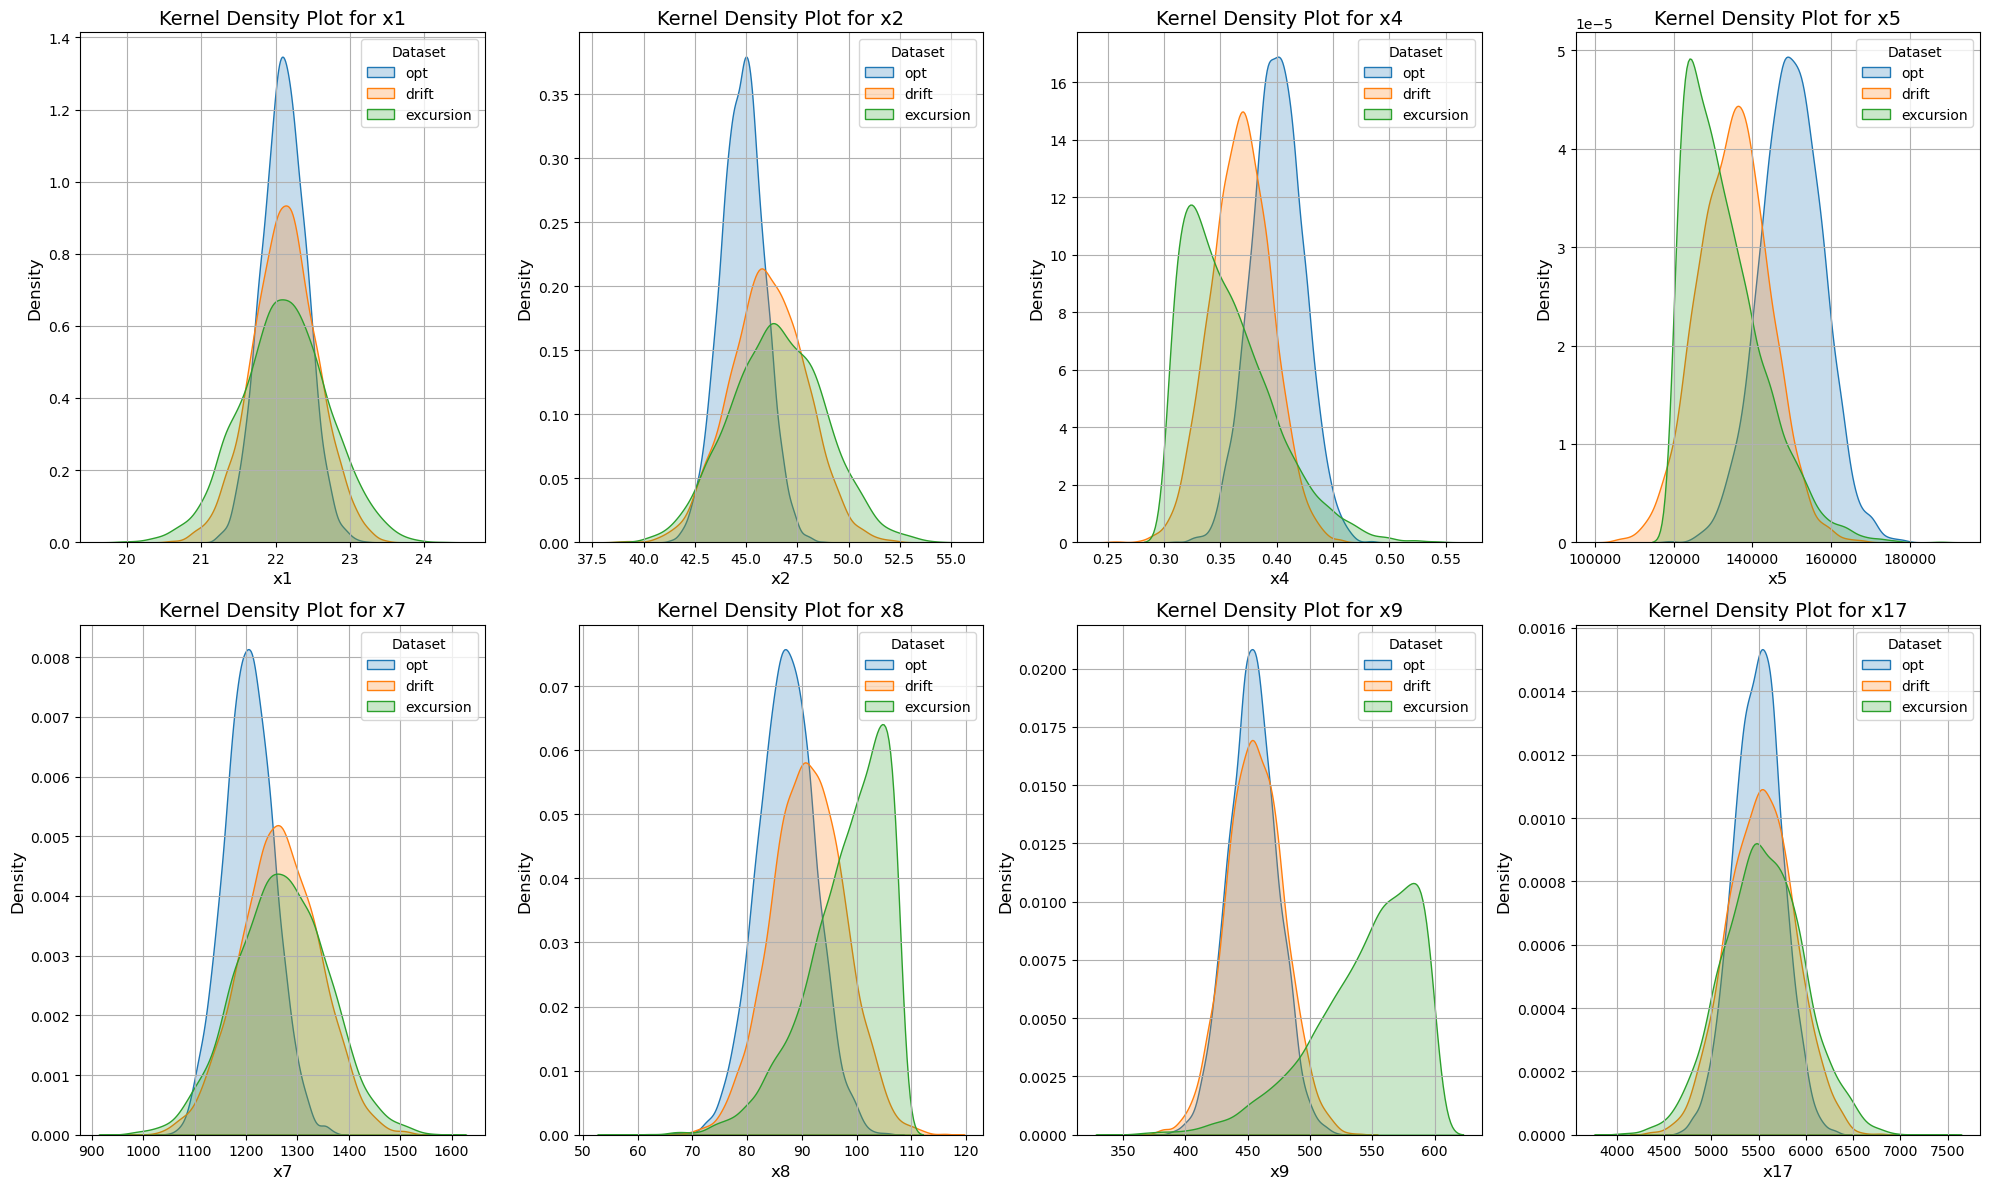

In [11]:
# Define the variables to be plotted
selected_variables = ['x1', 'x2', 'x4', 'x5', 'x7', 'x8', 'x9', 'x17']

# Define the plots per row for the selected variables
plots_per_row = 4
num_variables = len(selected_variables)
num_rows = (num_variables + plots_per_row - 1) // plots_per_row 

# Create the figure for the variable plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, 6 * num_rows))
axes = axes.flatten()  

# Generate the plots for the selected variables
for i, variable in enumerate(selected_variables):
    ax = axes[i]
    for name, df in datasets.items():
        sns.kdeplot(df[variable], label=name, fill=True, ax=ax)
    ax.set_title(f'Kernel Density Plot for {variable}', fontsize=14)
    ax.set_xlabel(variable, fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.legend(title='Dataset')
    ax.grid(True)

# Remove excess subplots if needed
for j in range(len(selected_variables), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

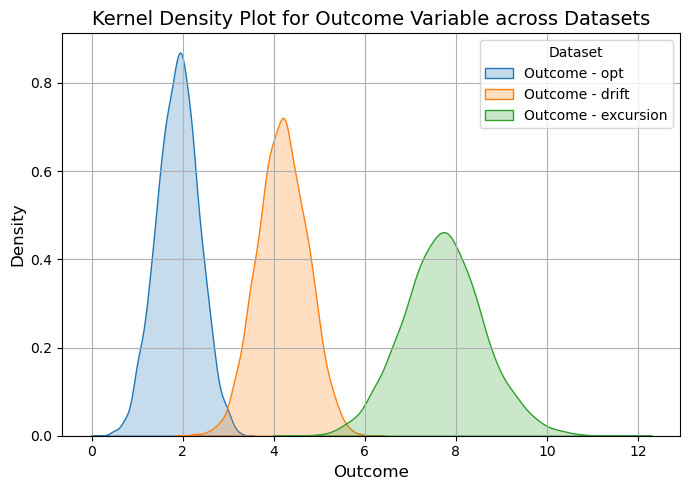

In [12]:
plt.figure(figsize=(7, 5))

# Loop over the datasets and plot the KDE for the 'outcome' variable in each
for name, df in datasets.items():
    sns.kdeplot(df['outcome'], label=f'Outcome - {name}', fill=True)

# Add labels and title
plt.title('Kernel Density Plot for Outcome Variable across Datasets', fontsize=14)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Dataset')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

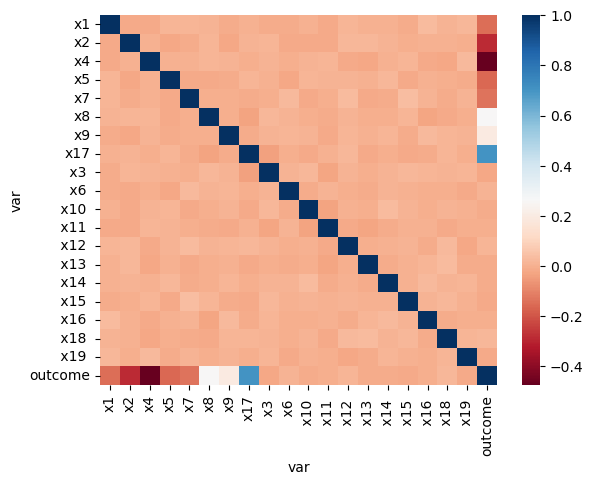

In [14]:
corr = drift_data.corr()

sns.heatmap(corr, 
            cmap='RdBu', 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

C:\Users\hrith\AppData\Local\Temp\ipykernel_20848\2079452644.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  interaction_table_binned = drift_data_cleaned.pivot_table(


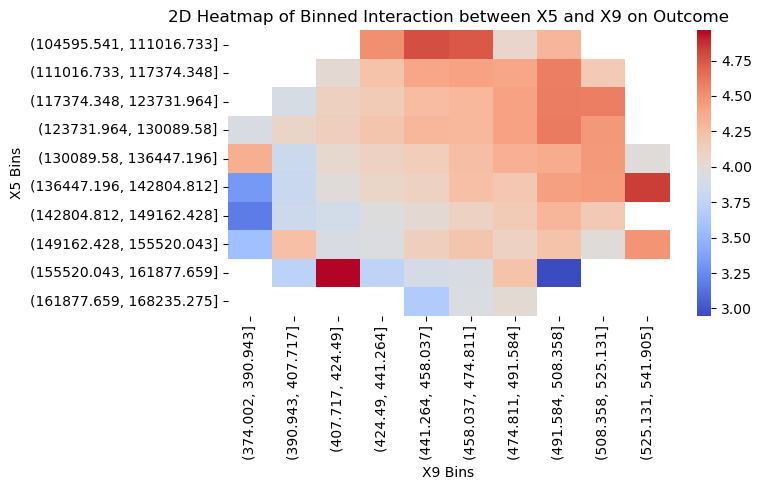

In [15]:
drift_data_cleaned = drift_data.dropna(subset=['x5', 'x9', 'outcome'])

drift_data_cleaned['x5_bins'] = pd.cut(drift_data_cleaned['x5'], bins=10)
drift_data_cleaned['x9_bins'] = pd.cut(drift_data_cleaned['x9'], bins=10)

# Create a pivot table with the binned values
interaction_table_binned = drift_data_cleaned.pivot_table(
    values='outcome', 
    index='x5_bins', 
    columns='x9_bins', 
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(interaction_table_binned, cmap="coolwarm", annot=False)
plt.title("2D Heatmap of Binned Interaction between X5 and X9 on Outcome")
plt.xlabel("X9 Bins")
plt.ylabel("X5 Bins")
plt.tight_layout()
plt.show()